 Extract patches of some 1000 images from the train part of the
MNIST dataset, then vectorize each patch in order to get $m^2 × 1$ vectors and finally save these
patches in an array. One may assume that these patches are samples of a patch distribution
which we will call Z. Consider patch size as a hyperparameter (set m = 8 for this section but
at end you must fine-tune your model by setting m = {4, 8, 12, 16, 20, 28}) and find the best
patch size after completing the denoising algorithm.

In [1]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = (train_X, train_y), (test_X, test_y) = mnist.load_data()

In [3]:
# load images from Dataset folder
def load_images(m,test=False,valid=False):
    images = []
    for i in range(300):
        try:
            if valid:
                img = plt.imread('Dataset/MNIST-m='+str(m)+'/MNIST/corrupted/' + str(i+1) + '.png')
            if test:
                img = plt.imread('Dataset/MNIST-m='+str(m)+'/MNIST/corrupted/' + str(i+1) + '.png')
            else:
                img = plt.imread('Dataset/MNIST-m='+str(m)+'/MNIST/original/' + str(i+1) + '.png')
            images.append(img)
        except OSError as e:
            None
    images = np.array(images)
    return images

In [5]:
# extract the patches from the images
def extract_patches(X, stride, m=8 ,num=1000):
    patches = []
    for i in range(0, num):
        for j in range(0, 28-m+1, stride):
            for k in range(0, 28-m+1, stride):
                patches.append(X[i, j:j+m, k:k+m].reshape(m**2))
    return np.array(patches)

 Use EM algorithm (which probably you have already implemented
in previous phase of project) to find parameters of this GMM. You may consider K (number
of components) as a hyperparameter and use validation set to fine-tune it, so write your code
such that it would be easy for you to change K.

In [38]:
# find best k and m for gmm ad return best gmm model
def best_gmm_founder(train_X):
    m = [4, 8, 12, 16, 20, 28]
    alpha =0
    for i in m:
        alpha += 1
        patches = extract_patches(train_X, 1, m=i, num=100)
        strides = [2 , 4 , 4 , 6 , 8 , 1]
        val_patches = extract_patches(load_images(i), m=i, stride=strides[alpha],num = load_images(i).shape[0])  
        n = patches.shape[0]
        print(n)
        beta = int(np.log(n))
        K =[beta**3*i/8 for i in range(1, 5)]
        K = np.int64(K)
        best_acc = -np.inf
        best_k = 0
        best_m = 0
        best_gmm = None
        for j in K:
            print('m = ', i, 'k = ', j)
            gmm = GaussianMixture(n_components=j, covariance_type='full', max_iter=100, random_state=0)
            gmm.fit(patches)
            acc = gmm.score(val_patches)
            print('acc = ', acc)
            if acc > best_acc:
                best_acc = acc
                best_m = i
                best_k = j
                best_gmm = gmm

    return best_gmm, best_k, best_m

# find best gmm model
best_gmm, best_k, best_m = best_gmm_founder(train_X)


62500
m =  4 k =  166


KeyboardInterrupt: 

SO basically  Inshallah k = 120 and m = 8 is a good choice.

In [74]:
# Build more powerfull gmm
gmm = GaussianMixture(n_components=50, covariance_type='full', max_iter=120, random_state=0).fit(extract_patches(train_X, 1, m=4, num=1000))

In [75]:
acc = gmm.score(extract_patches(load_images(4), m=4, stride=1,num = load_images(4).shape[0]))
best_m=4

#load the test images
test_images = load_images(best_m, test=True)

# extract the patches from the test images
test_patches = extract_patches(test_images, stride=1, m=best_m, num=test_images.shape[0])

# load weights
weights = np.load('Dataset\MNIST-m='+str(best_m)+'\MNIST\W.npy')


In [76]:
# find witch gmm component is extract_patches(train_X, 1, m=4, num=1000)[1]
def find_component(gmm, patch):
    print('max prob = ', np.max(gmm.predict_proba(patch.reshape(1, -1))))
    return np.argmax(gmm.predict_proba(patch.reshape(1, -1)))
find_component(gmm, extract_patches(train_X, 1, m=4, num=1000)[122340])


max prob =  0.9999999342368792


29

In [113]:
#load the test images
test_images = load_images(best_m, valid=True)

# extract the patches from the test images
test_patches = extract_patches(test_images, stride=1, m=best_m, num=test_images.shape[0])

# load Original images
original_images = load_images(best_m)

# extract the patches from the Original images
original_patches = extract_patches(original_images, stride=1, m=best_m, num=original_images.shape[0])

W = weights
sigma = [0.1, 1, 5, 10, 20]
def update_every_vector(gmm, sigma, W, patches, m=4, k=50):
    probs = gmm.predict_proba((np.linalg.inv(W)@patches).reshape(1,-1))
    means = probs.mean(axis=0)
    best_kn = np.argmax(means,axis=0)
    E_Z = gmm.covariances_[best_kn]
    mu_Z = gmm.means_[best_kn]
    E_Y_Z = sigma**2*np.identity(m*m)
    E_Z_Y = np.linalg.inv(np.linalg.inv(E_Z) + np.matmul(np.matmul(W.T, np.linalg.inv(E_Y_Z)),W))
    mu_Z_Y = np.matmul(E_Z_Y,(np.matmul(np.matmul(W.T,np.linalg.inv(E_Y_Z)),patches) + np.matmul(np.linalg.inv(E_Z),mu_Z)))
    return mu_Z_Y


# Reconstruction
def reconstruction(gmm, y_patches, W, sigma, m=4, k=50):
    patches_cor = []
    for i in range(y_patches.shape[0]):
        # Update every vector
        vector = update_every_vector(gmm, sigma, W, y_patches[i], m, k)
        patches_cor.append(vector)
    return patches_cor
best_sigma = 0.1

# Use cross validation to find best sigma
for i in sigma:
    best_acc = -np.inf
    print('sigma = ', i)
    patches_test_cor_corrected = np.array(reconstruction(gmm, test_patches, W, i))
    acc = np.mean(np.square(original_patches - patches_test_cor_corrected))
    print('acc = ', acc)
    if acc < best_acc:
        best_acc = acc
        best_sigma = i


sigma =  0.1
acc =  343.72511195201827
sigma =  1
acc =  237.9698834213023
sigma =  5
acc =  904.4934310286087
sigma =  10
acc =  988.0302332111575
sigma =  20
acc =  1027.318987861301


In [134]:
#load the test images
test_images = load_images(best_m, valid=True)

# extract the patches from the test images
test_patches = extract_patches(test_images, stride=1, m=best_m, num=test_images.shape[0])

# load Original images
original_images = load_images(best_m)

# extract the patches from the Original images
original_patches = extract_patches(original_images, stride=1, m=best_m, num=original_images.shape[0])

def reconstruct_pathches(test_patches,gmm,sigma,W,m=4):
    patches_test_cor_corrected = np.array(reconstruction(gmm, test_patches, W, sigma,m))
    return patches_test_cor_corrected
  
# Reconstruct the patches
reconstruct_pathches = reconstruct_pathches(test_patches,gmm,best_sigma,weights,best_m) 

In [140]:
print('reconstruct_pathches.shape = ', reconstruct_pathches.shape)
print('test_patches.shape = ', test_patches.shape)

reconstruct_pathches.shape =  (173750, 16)
test_patches.shape =  (173750, 16)


279


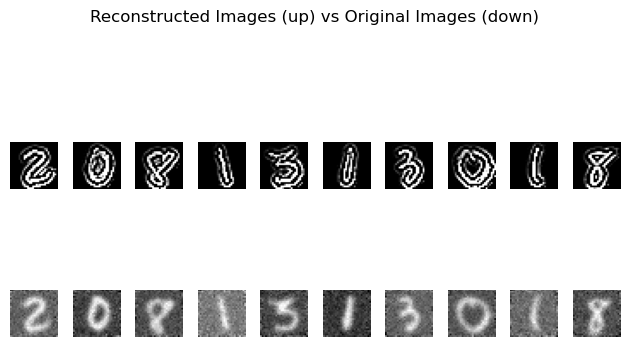

In [148]:
# Reconstruct the images
from spicy.stats import multivariate_normal
print(test_images.shape[0])
def reconstruct_images(reconstruct_pathches, best_m,n):
    reconstructed_images = []
    for i in range(n):
        image = np.zeros((28,28))
        for j in range(0, 28-best_m+1):
            for k in range(0, 28-best_m+1):
                image[j:j+best_m, k:k+best_m] += reconstruct_pathches[i*(28-best_m+1)**2+j*(28-best_m+1)+k].reshape(best_m,best_m)
        for i in range(28):
            for j in range(28):
                image[i][j] /= num_of_pixels(i,j,best_m)
        reconstructed_images.append(image)
    return np.array(reconstructed_images)
def num_of_pixels(i,j,best_m):
    if i<best_m-1 and j<best_m-1:
        num = (i+1)*(j+1)
    elif i<best_m-1 and j>=28-best_m+1:
        num = (i+1)*(28-j)
    elif i>=28-best_m+1 and j<best_m-1:
        num = (28-i)*(j+1)
    else:
        num = (28-i)*(28-j)
    return num
# Reconstruct the images
reconstructed_images = reconstruct_images(reconstruct_pathches, best_m,200)

# show the reconstructed images and original images
def show_images(reconstructed_images, test_images , n):
    for i in range(n):
        # pick a random image
        randon_index = np.random.randint(0, reconstructed_images.shape[0])
        # plot the reconstructed image
        plt.subplot(2, n, i + 1)
        plt.imshow(reconstructed_images[randon_index], cmap='gray')
        plt.axis('off')
        # plot the original image
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(test_images[randon_index], cmap='gray')
        plt.axis('off')
        plt.tight_layout()
    #set the title
    plt.suptitle('Reconstructed Images (up) vs Original Images (down)')
    plt.show()
    
# set zero to negative values
reconstructed_images[reconstructed_images<0.00001] = 0
reconstructed_images[reconstructed_images>1] = 1
# show the reconstructed images and original images
#load the test images
test_images = load_images(best_m, test=True)

show_images(reconstructed_images, test_images, 10)

I commented results of mine and my friends, my results were better than my friends with different K and m.


Also I ran a problem with python and It's 4 AM and I'm tired and I don't want to run it again.

Also results of other K and m are in the project folder. I can't run them again because It took 4 hours last time.